In [1]:
import sys
sys.path.append('/Users/dmelgarm/code/python/GMPEs/')
    
from gmpe_tools import bssa14,bssa14_one_station,cua_envelope
from numpy import ones,array,zeros,arange,linspace,genfromtxt,meshgrid,argmin,unique,where
from matplotlib import pyplot as plt
from netCDF4 import Dataset
from numpy.random import normal,uniform
import time

%matplotlib notebook

## What is the expected intensity of shaking in an earthquake?

The intensity of shaking is often referred to in seismology as the "ground motion". One of the most common metrics that we pay attention to in ground motion is the peak ground acceelration or PGA. Over the years we have come up with Ground Motion Prediction Equations, these are a system of quations that take in magnitude and dsitance from a site to an earthquake and "predict" the intensity.

I have coded up one of these systems of quations simply abbreviated BSSA14 fromt he authros and year of the paper. Below is a simple example of how to sue the function to estimate ground motion for a set of distances (variable Rjb) and for a given magnitude.

In [2]:
#number of distances
Ndist=1000

#Distance range in km
mindist=0.5
maxdist=100

# Distances vector the "jb" is in honor of Joyner and Boore who did this kind 
# of work first (all the way back circa 1980).
Rjb=linspace(mindist,maxdist,Ndist)

#Magnitude of event, make same length as distance vector
M=6.0*ones(Ndist)

#Uselessv ariables that describe the "type of fault" which we need not worry about now
U=ones(Ndist)
NS=zeros(Ndist)
RS=zeros(Ndist)
SS=zeros(Ndist)

# Site condition, to be explained later.
Vs30=200.*ones(Ndist)

#get the pga, also obtains "uncertainty" in the prediction
pga,sigma=bssa14(M,Rjb,Vs30=Vs30,U=U,NS=NS,RS=RS,SS=SS)

The prediction is in g's (because engineers), I prefer to convert it to m/s/s, we then plot in loglog

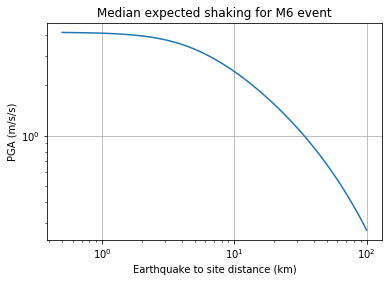

In [3]:
plt.loglog(Rjb,pga*9.81)
plt.ylabel('PGA (m/s/s)')
plt.xlabel('Earthquake to site distance (km)')
plt.title('Median expected shaking for M%d event' % M[0])
plt.grid()

This looks good. Note we've neglected "fault finitness" this means that earthquakes are not really point sources, they have finite extent. Up to about M6 that's ok, larger than that the point source assumption is **really** wrong (an M6 is about 8km long). If we want to we can add fault finitness the BSSA14 function has that capability, it's just more hassle.


## What about "site effects"?

Now one thing we really should add is this site condition bussiness. Basically it matters whether a site is on hard rock or soft soil. We characterize that site condition based on the seismic wave velocity in the topmost 30m of rock. This is called the Vs30, low Vs30s are something like 100m/s, think fill in SF bay, and this is bad, it amplifies ground motion. High Vs30s are somethong like 1500m/s (Sierra granite) and they don't amplify ground motions.

The USGS has a map of estimated Vs30s for the whole world (https://earthquake.usgs.gov/data/vs30/), let's load up the California map, it's a NetCDF file

In [4]:
vs30_file='/Users/dmelgarm/Vs30/california_latlon.xyz'
vs30_data = genfromtxt(vs30_file)

#coordinates
lon=vs30_data[:,0]
lat=vs30_data[:,1]

#get the actual vs30 values
vs30=vs30_data[:,2]

Text(0.5,1,'California region vs30 (m/s)')

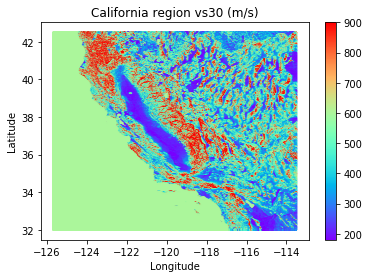

In [5]:
#make a plot to check everything is ok
plt.figure()
plt.scatter(lon,lat,c=vs30,cmap='rainbow',lw=0,s=2)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('California region vs30 (m/s)')

## Intensity is a static value, what about time dependence?

Ok, now we have a way to make simulated PGA, and we can add site effects. Now we need to simulate the **time dependence** of the shaking, that is to say the seismogram itself. Because PGA doesn;t just happen instantaneously it takes some time to grow. One very silly way to do this is to make the seimsogram be white noise, apply a windowing function that **looks** like what a seismogram looks like and rescale it so we get the desired PGA.

We're going to used a pre-canned windowing function, or envelope, from Cua & Heaton. We apply this to an example site. The window has a P-wave and an S-wave segments, the times at ewhoch these arrive will depend on the P-wave and S-wave speeds in the Earth we use some nominal reference values of 3 and 5km/s

In [6]:
distance=60 #in km
mag=6.0 #eq magnitude
p_speed=5.
s_speed=3.

#when do the p and s waves arrive tot eh site?
ptime=distance/p_speed
stime=distance/s_speed

#time vector
dt=0.01 #100Hz data
t=arange(0,60,dt) #0 is earthquake origin time


Text(25.5,21,'S-wave\npacket')

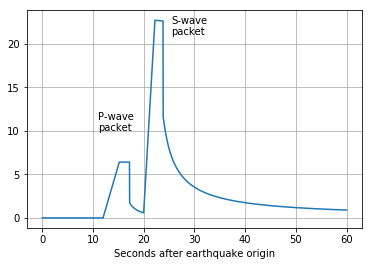

In [7]:
envelope=cua_envelope(mag,distance,t,ptime,stime,Pcoeff=0,Scoeff=12)

#plot it to check
plt.figure()
plt.plot(t,envelope)
plt.xlabel('Seconds after earthquake origin')
plt.grid()

#add some labels
plt.annotate(s='P-wave\npacket',xy=(11,10))
plt.annotate(s='S-wave\npacket',xy=(25.5,21))

Ok great now let's fill it in with white noise, the variance is unimportant for this toy example. Then we rescale it to match the PGA from the GMPE

In [8]:
#First get teh target PGA
dummy_vs30=200.
pga,sigma=bssa14_one_station(mag,distance,Vs30=dummy_vs30,U=0,NS=0,RS=0,SS=0)

#convert pga to m/s/s
pga=pga*9.81

In [9]:
mean=0
std=1
white_noise = normal(mean, std, size=len(t))

#Apply window
seismogram=envelope*white_noise

#rescale peak value to pga
max_value=max(abs(seismogram))
seismogram=(seismogram/max_value)*pga

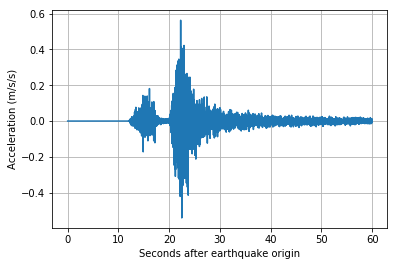

In [10]:
#plot to check
plt.figure()
plt.plot(t,seismogram)
plt.xlabel('Seconds after earthquake origin')
plt.ylabel('Acceleration (m/s/s)')
plt.grid()

## Where are the actual stations?

Henceforth I'll focus on Southern Claifornia and the LA region since it has the densest coverage of seismic stations. The following "channel" file has the current distribution of stations used by ShakeAlert in SoCal.

You'll notice by inspecting that file that one site cna have many channels associated with it, that is because each component of a 3-component seismomenter (North, East, Vertical) is assigned it's own channel. Furthermore each site can have several different kinds of seismometer. For our purposes we can simply remove all these duplciates and keep the unique stations.

Text(0,0.5,'Latitude')

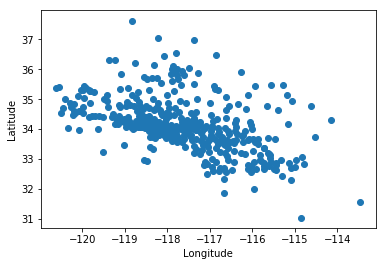

In [11]:
channels='/Users/dmelgarm/ShakeAlert/channels/ci_chanfile.dat'

#coordinates
lat=genfromtxt(channels,usecols=[4])
lon=genfromtxt(channels,usecols=[5])

#separate out into network and station codes
network=genfromtxt(channels,dtype='S',usecols=[0])
station=genfromtxt(channels,dtype='S',usecols=[1])

#combine net and site code into one string
site=station.copy().astype('S8')
for k in range(len(network)):
    site[k]=network[k]+'.'+station[k]

#get indices of the unqiue ones
values,indices=unique(site,return_index=True)

#keep only unqie lat,lon
lat=lat[indices]
lon=lon[indices]

#plot to check
plt.figure()
plt.scatter(lon,lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Putting it all together, make everything a set of functions

To review, from the BSSA14 GMPE we can estimate PGA at any given site. We can add site effects from known vs30, and we can shape the time evolution of the shaking using an envelope function to **look** like a seismogram. Obviously there are tons of asusmptions, this is jsut so we can make toy examples to play with.

Ok, now we need a set of functions to produce this en masse, we need one function to make the final shakemap for the **entire** domain. We then need a function to make the 3-component seismograms at the locations of **currently available** seismic sites. Then, the goal would be to train an algorithm to take in the seismograms and predict the full shakemap as time evolves.

Ok let's first copy code from above and write a function that makes entire shakemaps

In [12]:
#things that will go into the function, let's focus on LA region broadly 
min_lon,max_lon = -119,-116
min_lat,max_lat = 33,35
dx=0.02 #spacing for shakemap

lon=arange(min_lon,max_lon,dx)
lat=arange(min_lat,max_lat,dx)

#make 2D array then unravel
lon,lat=meshgrid(lon,lat)
lon=lon.ravel()
lat=lat.ravel()

In [ ]:
'''
now get vs30's at each location, no easy way to do this except to loop
over location and find closest value from original vs 30 grid, thankfully
only needs to be done once
'''
vs30_file='/Users/dmelgarm/Vs30/california_latlon.xyz'
vs30_data = genfromtxt(vs30_file)

#coordinates
lon_vs30=vs30_data[:,0]
lat_vs30=vs30_data[:,1]

#get the actual vs30 values
vs30_grid=vs30_data[:,2]

#initalize output
vs30=zeros(len(lon))

for k in range(len(lon)):
    
    #distance from shakempa point to vs30 grid point
    dist=((lon[k]-lon_vs30)**2+(lat[k]-lat_vs30)**2)**0.5
    
    #closest grid point
    i=argmin(dist)
    
    vs30[k]=vs30_grid[i]
    
    

In [ ]:
#plot to check
plt.scatter(lon,lat,c=vs30,s=4)
plt.axis('equal')
cb=plt.colorbar()
cb.set_label('vs30 (m/s)')

In [ ]:
#now finally the damn function

def make_shakemap(magnitude,epicenter_lon,epicenter_lat,lon,lat,vs30):
    
    from pyproj import Geod
    
    #make distances vector, dist from shakemap grid point to epicenter
    p=Geod(ellps='WGS84')
    az,baz,dist=p.inv(lon,lat,epicenter_lon*ones(len(lon)),epicenter_lat*ones(len(lat)))
    
    #distance to km
    dist=dist/1000.
    
    #number of points
    Ndist=len(lon)
    
    #Magnitude of event, make same length as distance vector
    M=magnitude*ones(Ndist)

    #Uselessv ariables that describe the "type of fault" which we need not worry about now
    U=ones(Ndist)
    NS=zeros(Ndist)
    RS=zeros(Ndist)
    SS=zeros(Ndist)

    #get the pga, also obtains "uncertainty" in the prediction
    pga,sigma=bssa14(M,dist,Vs30=vs30,U=U,NS=NS,RS=RS,SS=SS)
    
    return pga

In [ ]:
#let's try it out
epicenter_lon=-118.05
epicenter_lat=34.15
mag=6.2

#Make shakemap and convert to m/s/s
pga=make_shakemap(mag,epicenter_lon,epicenter_lat,lon,lat,vs30)
pga=pga*9.81

In [ ]:
#plot the shakemap
plt.figure()
plt.scatter(lon,lat,c=pga,cmap='nipy_spectral_r',s=2)
cb=plt.colorbar()
cb.set_label('PGA (m/s/s)')
plt.scatter(epicenter_lon,epicenter_lat,marker='*',c='w',s=200,lw=1,edgecolor='k')
plt.axis('equal')

That worked pretty well, how fast can we run tons and tons of shakemaps?

In [ ]:
Nmaps=5000

start = time.time()
for k in range(Nmaps):
    
    #random epicenter
    epicenter_lon=uniform(low=-119,high=-116)
    epicenter_lat=uniform(low=33,high=35)
    pga=make_shakemap(mag,epicenter_lon,epicenter_lat,lon,lat,vs30)

end = time.time()
print('It took %.2f seconds to run %d shakemaps' % (end - start,Nmaps))

That seems to be fast enough to play games. Roughly 100 per second, so in one day (86,400 seconds) you could make almost one million

Now a function to generate the 3 component seismogram at a particular set of stations

In [ ]:
# first copy the code from above to get the unique station coordinates from a chan file
channels='/Users/dmelgarm/ShakeAlert/channels/ci_chanfile.dat'

#coordinates
station_lat=genfromtxt(channels,usecols=[4])
station_lon=genfromtxt(channels,usecols=[5])

#separate out into network and station codes
network=genfromtxt(channels,dtype='S',usecols=[0])
station=genfromtxt(channels,dtype='S',usecols=[1])

#combine net and site code into one string
site=station.copy().astype('S8')
for k in range(len(network)):
    site[k]=network[k]+'.'+station[k]

#get indices of the unqiue ones
values,indices=unique(site,return_index=True)

#keep only unqie lat,lon
station_lat=station_lat[indices]
station_lon=station_lon[indices]

#keep only stations within the specified lat and lon box
i=where((station_lat<max_lat) & (station_lat>min_lat) & (station_lon>min_lon) & (station_lon<max_lon))[0]
station_lat=station_lat[i]
station_lon=station_lon[i]
        
        
        
#get teh Vs30 values at the locations of the stations

#initalize output
station_vs30=zeros(len(station_lon))

for k in range(len(station_lon)):
    
    #distance from shakempa point to vs30 grid point
    dist=((station_lon[k]-lon_vs30)**2+(station_lat[k]-lat_vs30)**2)**0.5
    
    #closest grid point
    i=argmin(dist)
    
    station_vs30[k]=vs30_grid[i]
    
#plot to check
plt.figure()
plt.scatter(station_lon,station_lat,c=station_vs30)
plt.colorbar()

In [ ]:
# Now the function

magnitude=6.1
epicenter_lon=-118.05
epicenter_lat=34.15

def make_seismograms(t,station_lon,station_lat,station_vs30,magnitude,epicenter_lon,epicenter_lat,
                    pwave_speed=5.0,swave_speed=3.5):
    
    #how many stations?
    Nsta=len(station_lon)
    
    from pyproj import Geod
    
    #make distances vector, dist from station to epicenter
    p=Geod(ellps='WGS84')
    az,baz,dist=p.inv(station_lon,station_lat,epicenter_lon*ones(Nsta),epicenter_lat*ones(Nsta))
    
    #distance to km
    dist=dist/1000.
    
    #Magnitude of event, make same length as distance vector
    M=magnitude*ones(Nsta)

    #Useless variables that describe the "type of fault" which we need not worry about now
    U=ones(Ndist)
    NS=zeros(Ndist)
    RS=zeros(Ndist)
    SS=zeros(Ndist)

    #get the pga, also obtains "uncertainty" in the prediction
    pga,sigma=bssa14(M,dist,Vs30=station_vs30,U=U,NS=NS,RS=RS,SS=SS)
    pga=pga*9.81 # to m/s/s
    
    # we will fake the 3 component seismogram, North and East will each have a peak of pga/sqrt(2)
    # vertical will be whatever north and east are /sqrt(3)
    
    Npga=pga/2**0.5
    Epga=pga/2**0.5
    Zpga=Npga/3**0.5
    
    #Out put variables, seismograms will be columns ine ach array, rows are time
    N=zeros((len(t),Nsta))
    E=zeros((len(t),Nsta))
    Z=zeros((len(t),Nsta))
    
    #white noise parameters
    mean=0
    std=1

    #make seismograms one station at a time
    for k in range(Nsta):
    
        north = normal(mean, std, size=len(t))
        east = normal(mean, std, size=len(t))
        up = normal(mean, std, size=len(t))
        
        #when doe the P and S phases arrive?
        ptime=dist[k]/pwave_speed
        stime=dist[k]/swave_speed
        
        # make the per component envelopes note Pcoeff, Scoeff are different for vertical
        n_envelope=cua_envelope(magnitude,dist[k],t,ptime,stime,Pcoeff=0,Scoeff=12)
        e_envelope=cua_envelope(magnitude,dist[k],t,ptime,stime,Pcoeff=0,Scoeff=12)
        z_envelope=cua_envelope(magnitude,dist[k],t,ptime,stime,Pcoeff=6,Scoeff=18)

        #Apply window
        north=n_envelope*north
        east=e_envelope*east
        up=z_envelope*up

        #rescale peak value to pga
        north=(north/north.max())*Npga[k]
        east=(east/east.max())*Epga[k]
        up=(up/up.max())*Zpga[k]
        
        #place in output variable
        N[:,k]=north
        E[:,k]=east
        Z[:,k]=up
    
    return N,E,Z
    

In [ ]:
# did it work????

N,E,Z=make_seismograms(t,station_lon,station_lat,station_vs30,magnitude,epicenter_lon,epicenter_lat)

#plot one station
plt.figure()
ksta=20
offset=1
plt.plot(t,N[:,ksta],t,E[:,ksta]+offset,t,Z[:,ksta]+2*offset,lw=0.5)
plt.legend(['North','East','Up'])
plt.ylabel('Acceleration (m/s/s)')
plt.xlabel('Seconds since earthquake origin')

In [ ]:
# Well I'll be... that looks good. Let's plot one channel
# say north as a function of distance to the source so see it makes sense

#how many stations?
Nsta=len(station_lon)

from pyproj import Geod

#make distances vector, dist from station to epicenter
p=Geod(ellps='WGS84')
az,baz,dist=p.inv(station_lon,station_lat,epicenter_lon*ones(Nsta),epicenter_lat*ones(Nsta))

#distance to km
dist=dist/1000.

plt.figure()
for k in range(Nsta):
    seismogram=N[:,k]
    
    # Rescale for plot?
    # seismogram=seismogram/abs(max(seismogram))
    seismogram=seismogram*5
    
    plt.plot(t,seismogram+dist[k],c='k',lw=0.2)
    
plt.xlabel('Seconds after earthquake origin')
plt.ylabel('Distance from earthquake (km)')

This looks good you can see two distinct "phases" the P-wave propagating faster across the array and the slower S wave.

In [ ]:
#now how fast does it run?

Nevents=100

start = time.time()
for k in range(Nevents):
    
    #random epicenter
    epicenter_lon=uniform(low=-119,high=-116)
    epicenter_lat=uniform(low=33,high=35)
    N,E,Z=make_seismograms(t,station_lon,station_lat,station_vs30,magnitude,epicenter_lon,epicenter_lat)

end = time.time()
print('It took %.2f seconds to simualte %d earthquakes at %d stations' % (end - start,Nevents,len(station_lon)))

This is slower than the shakemaps, roughly each earthquake takes ~0.4s so in one day one could simulate ~200,000, still not bad!